In [0]:
!pip3 -qq install torch==0.4.1
!pip install -q --upgrade nltk gensim bokeh pandas

!wget -O quora.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1ERtxpdWOgGQ3HOigqAMHTJjmOE_tWvoF"
!unzip quora.zip

import nltk
nltk.download('punkt')

In [0]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

np.random.seed(42)

# Введение в PyTorch

PyTorch - это один из самых известных фреймворков для работы с нейронными сетями.

Почему именно он? Ну, он няшен, питоняч и проще в отладке - по сравнению с монстрами типа tensoflow (хотя tf 2.0 с eager execution будет примерно таким же).

И вообще, мы тут не фреймворки, а сеточки учить собирались :)



## Автоматическое дифференцирование

### Графы вычислений

Графы вычислений - это такой удобный способ быстро считать градиенты сложных-пресложных функций.

Например, функция

$$f = (x + y) \cdot z$$

представится графом

![graph](https://image.ibb.co/mWM0Lx/1_6o_Utr7_ENFHOK7_J4l_XJtw1g.png =500x)  
*From [Backpropagation, Intuitions - CS231n](http://cs231n.github.io/optimization-2/)*

**Задание** Зададим значения $x, y, z$ (зеленым на картинке). Как посчитать $\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}, \frac{\partial f}{\partial z}$? (*Вспоминаем, что такое backpropagation*)

В PyTorch такие вычисления делаются очень просто.

Сначала определяется функция - просто последовательность операций:

In [0]:
x = torch.tensor(-2., requires_grad=True)
y = torch.tensor(5., requires_grad=True)
z = torch.tensor(-4., requires_grad=True)

q = x + y
f = q * z

А затем говорим ей: "Посчитай градиенты, пожалуйста"

In [4]:
f.backward()

print('df/dz =', z.grad)
print('df/dx =', x.grad)
print('df/dy =', y.grad)

df/dz = tensor(3.)
df/dx = tensor(-4.)
df/dy = tensor(-4.)


Вызов метода `backward()` вычисляет градиенты для всех тензоров, у которых `requires_grad == True`.

Есть еще альтернативный способ не вычислять градиенты - пользоваться менеджерами контекста ([Locally disabling gradient computation](https://pytorch.org/docs/stable/autograd.html#locally-disabling-gradient-computation)):
```python
torch.autograd.no_grad()
torch.autograd.enable_grad()
torch.autograd.set_grad_enabled(mode)

```

In [5]:
with torch.autograd.no_grad():
    x = torch.tensor(-2., requires_grad=True)
    y = torch.tensor(5., requires_grad=True)
    q = x + y

z = torch.tensor(-4., requires_grad=True)
f = q * z

f.backward()

print('df/dz =', z.grad)
print('df/dx =', x.grad)
print('df/dy =', y.grad)

df/dz = tensor(3.)
df/dx = None
df/dy = None


Подробнее о том, как работает autograd, можно почитать здесь: [Autograd mechanics](https://pytorch.org/docs/stable/notes/autograd.html).

В целом, любой тензор в pytorch - аналог многомерных матриц в numpy.

Он содержит данные:

In [6]:
x.data

tensor(-2.)

Накопленный градиент:

In [0]:
x.grad

Функцию, как градиент считать:

In [0]:
q.grad_fn

И всякую дополнительную метаинформацию:

In [9]:
x.type(), x.shape, x.device, x.layout

('torch.FloatTensor', torch.Size([]), device(type='cpu'), torch.strided)

Зачем... У меня один вопрос - зачем вот это вот нам нужно?

### Задача для разминки

Чтобы разобраться - решим простенькую задачу на линейную регрессию:

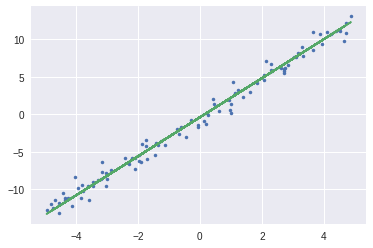

In [10]:
w_orig, b_orig = 2.6, -0.4

X = np.random.rand(100) * 10. - 5.
y_orig = w_orig * X + b_orig

y = y_orig + np.random.randn(100)

plt.plot(X, y, '.')
plt.plot(X, y_orig)
plt.show()

Хочется прикрутить сюда backpropagation, да.

Есть два параметра $w$ и $b$ - их нужно подобрать такими, чтобы они были как можно ближе к исходным $w_{orig}, b_{orig}$.

Что будем оптимизировать? Оптимизировать будем MSE:
$$J(w, b) = \frac{1}{N} \sum_{i=1}^N || \hat y_i - y_i(w, b)||^2 =\frac{1}{N} \sum_{i=1}^N || \hat y_i - (w \cdot x_i + b)||^2. $$

С такой функций потерь можем запустить простой градиентный спуск (даже не стохастический пока):
$$w_{t+1} := w_t - \alpha \cdot \frac{\partial J}{\partial w}(w_t, b_t)$$
$$b_{t+1} := w_t - \alpha \cdot \frac{\partial J}{\partial b}(w_t, b_t)$$

**Задание** Реализовать оптимизацию на чистом numpy.

Для этого нужно:
1. Посчитать значение функции на прямом проходе: $y(w, b) = w \cdot x + b$;
2. Подумать и посчитать градиенты $\frac{\partial J}{\partial w}, \frac{\partial J}{\partial b}$ на обратном проходе;
3. Сдвинуть $w, b$ по антиградиентам.

Epoch = 100, Loss = 0.8660062702228742, w = 2.5631309345346254, b = -0.1746547738005121


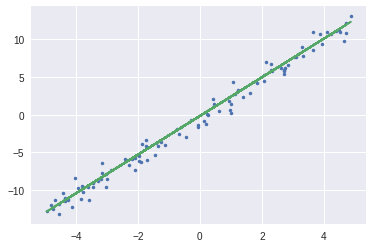

In [11]:
def display_progress(epoch, loss, w, b, X, y, y_pred):
    clear_output(True)
    print('Epoch = {}, Loss = {}, w = {}, b = {}'.format(epoch, loss, w, b))
    plt.plot(X, y, '.')
    plt.plot(X, y_pred)
    plt.show()
    time.sleep(1)


w = np.random.randn()
b = np.random.randn()

alpha = 0.01

for i in range(100):
    y_pred = X * w + b

    loss = np.mean((y - y_pred) ** 2)

    w_grad = 2 * np.mean((y_pred - y) * X)
    b_grad = 2 * np.mean(y_pred - y)

    w -= alpha * w_grad
    b -= alpha * b_grad
    
    if (i + 1) % 5 == 0:
        display_progress(i + 1, loss, w, b, X, y, y_pred)

На PyTorch то же самое сделать несколько проще - подсчет прямого прохода копируется почти дословно.

Обратный проход мы уже умеем - нужно просто вызвать `loss.backward()`.

Для обновления `w` и `b` нужно иметь в виду следующее. Во-первых, pytorch не даст просто так обновить их:

In [12]:
try:
    w = torch.randn(1, requires_grad=True)

    w -= 1.
except RuntimeError:
    print('Не надо так...')

Не надо так...


Проблема в сложности поддержки in-place операций для работы autograd ([In place operations with autograd](https://pytorch.org/docs/stable/notes/autograd.html#in-place-operations-with-autograd)).

Но нам и не нужна поддержка градиентов! Мы не будем делать backward pass через эту операцию - нужно всего лишь обновить значение переменной. Чтобы сделать это, можно воспользовать контекстом `no_grad`, либо производить обновление непосредственно буфера, который использует данный тензор:

In [0]:
w.data -= 1.

Другое, что нужно помнить - градиенты в тензорах накапливаются. Между вызовами `loss.backward()` нужно обнулять градиенты у `w` и `b`:
```python
w.grad.zero_()
b.grad.zero_()
```

**Задание** Реализовать линейную регрессию на pytorch.

Epoch = 100, Loss = 0.8070520162582397, w = 2.554830551147461, b = -0.39349082112312317


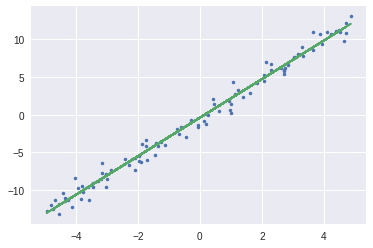

In [14]:
X = torch.as_tensor(X).float()
y = torch.as_tensor(y).float()

w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

for i in range(100):
    y_pred = X * w + b

    loss = ((y - y_pred) ** 2).mean()
    loss.backward()
    
    w.data -= alpha * w.grad
    b.data -= alpha * b.grad
    
    w.grad.zero_()
    b.grad.zero_()
    
    if (i + 1) % 5 == 0:
        display_progress(i + 1, loss, w.item(), b.item(), 
                         X.data.numpy(), y.data.numpy(), y_pred.data.numpy())

Думать нужно уже гораздо меньше, да? :)

Про другие фишки низкоуровнего pytorch можно почитать здесь: [PyTorch — ваш новый фреймворк глубокого обучения](https://habr.com/post/334380/) (статья веселая, но немного устарела, читать лучше с оглядкой на [PyTorch 0.4.0 Migration Guide](https://pytorch.org/blog/pytorch-0_4_0-migration-guide/))

## Word embeddings и высокоуровневый API PyTorch

Займёмся рассмотрением высокоуровневого API - в нем уже реализованы разные классы-запчасти для обучения нейронок.

Будем решать всё ту же задачу, что и в прошлый раз - обучение словных эмбеддингов, только теперь мы будем учить их самостоятельно!

Для начала нужно подготовить данные для обучения.

Соберем и токенизируем тексты:

In [0]:
import pandas as pd
from nltk.tokenize import word_tokenize

quora_data = pd.read_csv('train.csv')

quora_data.question1 = quora_data.question1.replace(np.nan, '', regex=True)
quora_data.question2 = quora_data.question2.replace(np.nan, '', regex=True)

texts = list(pd.concat([quora_data.question1, quora_data.question2]).unique())

tokenized_texts = [word_tokenize(text.lower()) for text in texts]

Соберем индекс самых частотных слов:

In [16]:
from collections import Counter

MIN_COUNT = 5

words_counter = Counter(token for tokens in tokenized_texts for token in tokens)
word2index = {
    '<unk>': 0
}

for word, count in words_counter.most_common():
    if count < MIN_COUNT:
        break
        
    word2index[word] = len(word2index)
    
index2word = [word for word, _ in sorted(word2index.items(), key=lambda x: x[1])]
    
print('Vocabulary size:', len(word2index))
print('Tokens count:', sum(len(tokens) for tokens in tokenized_texts))
print('Unknown tokens appeared:', sum(1 for tokens in tokenized_texts for token in tokens if token not in word2index))
print('Most freq words:', index2word[1:21])

Vocabulary size: 28657
Tokens count: 6969174
Unknown tokens appeared: 123674
Most freq words: ['?', 'the', 'what', 'is', 'a', 'i', 'to', 'in', 'how', 'of', 'do', 'are', 'and', 'for', ',', 'can', 'you', 'why', 'it', 'my']


### Skip-Gram Word2vec

Начнем с skip-gram модели обучения word2vec.

Это простая модель всего из двух слоев. Ее идея - учить вектора эмбеддингов такими, чтобы по ним можно было как можно лучше предсказать контекст соответствующих слов. То есть если мы хорошо научились кодировать слова, с которыми встречается данное - значит, мы что-то знаем и о нем самом. Например, естественным образом получится, что слова, встречающиеся в одинаковых контекстах (скажем, `apple` и `orange`)  будут иметь близкие вектора эмбеддингов.

![](https://ask.qcloudimg.com/http-save/yehe-1565119/pv4604cabp.jpeg =600x)  
*From cs224n, Lecture 2*

Для этого мы моделируем вероятности $\{P(w_{c+j}|w_c):  j = c-k, ..., c+k, k \neq c\}$, где $k$ - размер контекстного окна, $c$ - индекс центрального слова.

Соберем такую модель: будем учить пару матриц $U$ - матрицу эмбеддингов, которую потом и возьмем для своих задач, и $V$ - матрицу выходного слоя.

Каждому слову в словаре соответствует строка в матрице $U$ и столбец $V$.

![skip-gram](https://image.ibb.co/khFXu9/Skip_gram.png =500x)

Что тут происходит? Слово отображается в эмбеддинг - строку $u_c$. Дальше этот эмбеддинг умножается на матрицу $V$. 

В итоге получаем набор числе $v_j^T u_c$ - степень похожести слова с номером $j$ и нашего слова.

Преобразуем эти числа в что-то вроде вероятностей - воспользуемся функцией softmax: $P(i) = \frac{e^{x_i}}{\sum_j e^{x_j}}$.

А дальше будем считать кросс-энтропийные потери:

$$-\sum_{-k \leq j \leq k, j \neq 0} \log \frac{\exp(v_{c+j}^T u_c)}{\sum_{i=1}^{|V|} \exp(v_i^T u_c)} \to \min_{U, V}.$$

В итоге, вектор $u_c$ будет приближаться к векторам $v_{c_j}$ из его контекста.

Реализуем это всё, чтобы разобраться.

#### Генерация батчей

Для начала нужно собрать контексты.

In [0]:
def build_contexts(tokenized_texts, window_size):
    contexts = []
    for tokens in tokenized_texts:
        for i in range(len(tokens)):
            central_word = tokens[i]
            context = [tokens[i + delta] for delta in range(-window_size, window_size + 1) 
                       if delta != 0 and i + delta >= 0 and i + delta < len(tokens)]

            contexts.append((central_word, context))
            
    return contexts

In [0]:
contexts = build_contexts(tokenized_texts, window_size=2)

In [19]:
contexts[:5]

[('what', ['is', 'the']),
 ('is', ['what', 'the', 'step']),
 ('the', ['what', 'is', 'step', 'by']),
 ('step', ['is', 'the', 'by', 'step']),
 ('by', ['the', 'step', 'step', 'guide'])]

Преобразуем слова в индексы.

In [0]:
contexts = [(word2index.get(central_word, 0), [word2index.get(word, 0) for word in context]) 
            for central_word, context in contexts]

Реализуем генератор батчей для нашей нейронки:

In [0]:
import random

def make_skip_gram_batchs_iter(contexts, window_size, num_skips, batch_size):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * window_size
    
    central_words = [word for word, context in contexts if len(context) == 2 * window_size and word != 0]
    contexts = [context for word, context in contexts if len(context) == 2 * window_size and word != 0]
    
    batch_size = int(batch_size / num_skips)
    batchs_count = int(math.ceil(len(contexts) / batch_size))
    
    print('Initializing batchs generator with {} batchs per epoch'.format(batchs_count))
    
    while True:
        indices = np.arange(len(contexts))
        np.random.shuffle(indices)

        for i in range(batchs_count):
            batch_begin, batch_end = i * batch_size, min((i + 1) * batch_size, len(contexts))
            batch_indices = indices[batch_begin: batch_end]

            batch_data, batch_labels = [], []

            for data_ind in batch_indices:
                central_word, context = central_words[data_ind], contexts[data_ind]
                
                words_to_use = random.sample(context, num_skips)
                batch_data.extend([central_word] * num_skips)
                batch_labels.extend(words_to_use)
            
            yield batch_data, batch_labels

In [22]:
batch, labels = next(make_skip_gram_batchs_iter(contexts, window_size=2, num_skips=2, batch_size=32))

Initializing batchs generator with 295210 batchs per epoch


#### nn.Sequential

Простейший способ реализовать модель на PyTorch - использовать модуль `nn.Sequential`. В нем нужно просто перечислить все слои, и он будет применять их последовательно.

In [0]:
model = nn.Sequential(
    nn.Embedding(len(word2index), 32),
    nn.Linear(32, len(word2index))
)

Еще одна особенность pytorch, о которой до сих пор не говорили - поддержка вычислений на видеокарте. На видеокарте большинство нейронок считается гораздо быстрее благодаря высокой параллелизации. Сказать pytorch'у, чтобы он считал на видеокарте, очень просто:

In [24]:
model.cuda()

Sequential(
  (0): Embedding(28657, 32)
  (1): Linear(in_features=32, out_features=28657, bias=True)
)

либо

In [0]:
device = torch.device("cuda")

model = model.to(device)

Создать тензоры на видеокарте можно, например, так:

In [0]:
batch = torch.cuda.LongTensor(batch)
labels = torch.cuda.LongTensor(labels)

Заставить модель посчитать значение можно так:

In [0]:
logits = model(batch)

Теперь нам нужна функция потерь

In [0]:
loss_function = nn.CrossEntropyLoss().cuda() 

Посчитать значение можно так:

In [0]:
loss = loss_function(logits, labels)

А теперь, конечно же, backprop!

In [0]:
loss.backward()

И, наконец, оптимизатор.

Будем использовать Adam. Интерфейс - передать список оптимизируемых параметров и learning rate.

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.01) 

Оптимизация идет просто - нужно вызвать `step()`:

In [32]:
print(model[1].weight)

optimizer.step()

print(model[1].weight)

Parameter containing:
tensor([[-0.1489, -0.1388,  0.0433,  ...,  0.0225, -0.1270,  0.1069],
        [-0.1357,  0.1315, -0.1572,  ..., -0.0995, -0.0827,  0.1011],
        [ 0.0267, -0.0071,  0.1244,  ..., -0.0480,  0.0165, -0.0099],
        ...,
        [ 0.0497,  0.0177, -0.1657,  ..., -0.1449, -0.0221,  0.0277],
        [-0.1002,  0.1391, -0.0053,  ..., -0.1345,  0.1640, -0.0071],
        [-0.0551, -0.1068, -0.0598,  ...,  0.1517,  0.1154,  0.0208]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.1589, -0.1488,  0.0333,  ...,  0.0125, -0.1170,  0.1169],
        [-0.1457,  0.1415, -0.1672,  ..., -0.1095, -0.0927,  0.1111],
        [ 0.0367, -0.0171,  0.1344,  ..., -0.0380,  0.0265,  0.0001],
        ...,
        [ 0.0401,  0.0080, -0.1559,  ..., -0.1533, -0.0126,  0.0373],
        [-0.0905,  0.1297,  0.0044,  ..., -0.1437,  0.1541,  0.0013],
        [-0.0453, -0.1165, -0.0500,  ...,  0.1420,  0.1055,  0.0165]],
       device='cuda:0', requires_grad=True)


И последнее - нужно обнулить градиенты!

In [0]:
optimizer.zero_grad()

#### Реализация обучения skip-gram модели

Наконец, напишем цикл обучения - как уже было с линейной регрессией.

 **Задание** Заполните цикл.

In [34]:
loss_every_nsteps = 1000
total_loss = 0
start_time = time.time()

for step, (batch, labels) in enumerate(make_skip_gram_batchs_iter(contexts, window_size=2, num_skips=4, batch_size=128)):
    batch = torch.cuda.LongTensor(batch)
    labels = torch.cuda.LongTensor(labels)

    logits = model(batch)
    
    loss = loss_function(logits, labels)
    loss.backward()

    optimizer.step()
    
    optimizer.zero_grad()

    total_loss += loss.item()
    
    if step != 0 and step % loss_every_nsteps == 0:
        print("Step = {}, Avg Loss = {:.4f}, Time = {:.2f}s".format(step, total_loss / loss_every_nsteps, 
                                                                    time.time() - start_time))
        total_loss = 0
        start_time = time.time()

Initializing batchs generator with 147605 batchs per epoch
Step = 1000, Avg Loss = 7.4612, Time = 7.51s
Step = 2000, Avg Loss = 6.8489, Time = 4.70s
Step = 3000, Avg Loss = 6.7581, Time = 4.71s
Step = 4000, Avg Loss = 6.7061, Time = 4.71s
Step = 5000, Avg Loss = 6.6702, Time = 4.71s
Step = 6000, Avg Loss = 6.6484, Time = 4.72s
Step = 7000, Avg Loss = 6.6399, Time = 4.71s
Step = 8000, Avg Loss = 6.6292, Time = 4.72s
Step = 9000, Avg Loss = 6.6149, Time = 4.72s
Step = 10000, Avg Loss = 6.5922, Time = 4.72s
Step = 11000, Avg Loss = 6.5905, Time = 4.71s
Step = 12000, Avg Loss = 6.5921, Time = 4.72s
Step = 13000, Avg Loss = 6.5836, Time = 4.73s
Step = 14000, Avg Loss = 6.5849, Time = 4.72s
Step = 15000, Avg Loss = 6.5640, Time = 4.72s
Step = 16000, Avg Loss = 6.5505, Time = 4.72s
Step = 17000, Avg Loss = 6.5648, Time = 4.72s
Step = 18000, Avg Loss = 6.5489, Time = 4.72s
Step = 19000, Avg Loss = 6.5538, Time = 4.72s
Step = 20000, Avg Loss = 6.5412, Time = 4.72s
Step = 21000, Avg Loss = 6.531

KeyboardInterrupt: ignored

#### Анализ

Получить эмбеддинги можно, скаставав такое заклинание:

In [0]:
embeddings = model[0].weight.cpu().data.numpy()

Проверим, получилось ли хоть сколько-то адекватно.

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

def most_similar(embeddings, index2word, word2index, word):
    word_emb = embeddings[word2index[word]]
    
    similarities = cosine_similarity([word_emb], embeddings)[0]
    top10 = np.argsort(similarities)[-10:]
    
    return [index2word[index] for index in reversed(top10)]

most_similar(embeddings, index2word, word2index, 'warm')

['warm',
 'tap',
 'spicy',
 'melt',
 'beef',
 'beans',
 'frozen',
 'consume',
 'stress',
 'over']

И визуализируем!

In [37]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=100)
    return scale(tsne.fit_transform(word_vectors))
    
    
def visualize_embeddings(embeddings, index2word, word_count):
    word_vectors = embeddings[1: word_count + 1]
    words = index2word[1: word_count + 1]
    
    word_tsne = get_tsne_projection(word_vectors)
    draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=words)
    
    
visualize_embeddings(embeddings, index2word, 1000)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.090s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.059353
[t-SNE] Computed conditional probabilities in 0.074s
[t-SNE] Iteration 50: error = 78.3287811, gradient norm = 0.3291647 (50 iterations in 2.101s)
[t-SNE] Iteration 100: error = 82.1953201, gradient norm = 0.2894860 (50 iterations in 2.593s)
[t-SNE] Iteration 150: error = 81.4383316, gradient norm = 0.2995319 (50 iterations in 2.430s)
[t-SNE] Iteration 200: error = 83.1246796, gradient norm = 0.2731496 (50 iterations in 2.546s)
[t-SNE] Iteration 250: error = 82.8746567, gradient norm = 0.2745719 (50 iterations in 3.029s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.874657
[t-SNE] Iteration 300: error = 2.1104569, gradient norm = 0.0033431 (50 iterations in 2.029s)
[t-SNE] Iteration 350: error = 1.9605334, gradient norm = 0.00190

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Loading BokehJS ...

### Continuous Bag of Words (CBoW)

Альтернативный вариант модели:

![](https://image.ibb.co/jnsW49/CBOW.png =500x)

Теперь по *сумме* контекстных векторов предсказывается вектор центрального слова.

**Задание** Реализуйте часть функции для генерации батчей.

In [0]:
def make_cbow_batchs_iter(contexts, window_size, batch_size):
    data = np.array([context for word, context in contexts if len(context) == 2 * window_size and word != 0])
    labels = np.array([word for word, context in contexts if len(context) == 2 * window_size and word != 0])
        
    batchs_count = int(math.ceil(len(data) / batch_size))
    
    print('Initializing batchs generator with {} batchs per epoch'.format(batchs_count))
    
    while True:
        indices = np.arange(len(data))
        
        for i in range(batchs_count):
            batch_begin, batch_end = i * batch_size, min((i + 1) * batch_size, len(data))
            batch_indices = indices[batch_begin: batch_end]
            
            batch_data, batch_labels = [], []
            
            for data_ind in batch_indices:
                batch_data.extend([data[data_ind]])
                batch_labels.append(labels[data_ind])
            
            yield batch_data, batch_labels     

In [39]:
batch, label = next(make_cbow_batchs_iter(contexts, window_size=2, batch_size=128))

Initializing batchs generator with 36902 batchs per epoch


Посмотрим на альтернативный вариант создания модели - им мы будем пользоваться чаще всего - отнаследоваться от `nn.Module`. Схематично её использование выглядит так:

```python
class MyNetModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MyNetModel, self).__init__()
        <initialize layers>
        
    def forward(self, inputs):
        <apply layers>
        return final_output
```



In [0]:
class CBoWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        return self.out_layer(self.embeddings(inputs).sum(1))
      
model = CBoWModel(vocab_size=len(word2index), embedding_dim=32).cuda()

loss_function = nn.CrossEntropyLoss().cuda() 
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [41]:
loss_every_nsteps = 1000
total_loss = 0
start_time = time.time()

for step, (batch, labels) in enumerate(make_cbow_batchs_iter(contexts, window_size=2, batch_size=128)):
    batch = torch.cuda.LongTensor(batch)
    labels = torch.cuda.LongTensor(labels)

    logits = model(batch)
    
    loss = loss_function(logits, labels)
    loss.backward()

    optimizer.step()
    
    optimizer.zero_grad()

    total_loss += loss.item()
    
    if step != 0 and step % loss_every_nsteps == 0:
        print("Step = {}, Avg Loss = {:.4f}, Time = {:.2f}s".format(step, total_loss / loss_every_nsteps, 
                                                                    time.time() - start_time))
        total_loss = 0
        start_time = time.time()

Initializing batchs generator with 36902 batchs per epoch
Step = 1000, Avg Loss = 6.8030, Time = 10.76s
Step = 2000, Avg Loss = 6.1152, Time = 4.77s
Step = 3000, Avg Loss = 5.9472, Time = 4.76s
Step = 4000, Avg Loss = 5.8111, Time = 4.77s
Step = 5000, Avg Loss = 5.7222, Time = 4.77s
Step = 6000, Avg Loss = 5.6630, Time = 4.77s
Step = 7000, Avg Loss = 5.6335, Time = 4.77s
Step = 8000, Avg Loss = 5.6018, Time = 4.77s
Step = 9000, Avg Loss = 5.6007, Time = 4.77s
Step = 10000, Avg Loss = 5.5770, Time = 4.77s
Step = 11000, Avg Loss = 5.5703, Time = 4.77s
Step = 12000, Avg Loss = 5.5790, Time = 4.77s
Step = 13000, Avg Loss = 5.5437, Time = 4.77s
Step = 14000, Avg Loss = 5.5253, Time = 4.77s
Step = 15000, Avg Loss = 5.5481, Time = 4.76s
Step = 16000, Avg Loss = 5.5399, Time = 4.77s
Step = 17000, Avg Loss = 5.5342, Time = 4.78s
Step = 18000, Avg Loss = 5.5374, Time = 4.78s
Step = 19000, Avg Loss = 5.5457, Time = 4.78s
Step = 20000, Avg Loss = 5.3955, Time = 4.77s
Step = 21000, Avg Loss = 5.390

KeyboardInterrupt: ignored

In [42]:
visualize_embeddings(model.embeddings.weight.data.cpu().numpy(), index2word, 1000)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.074639
[t-SNE] Computed conditional probabilities in 0.049s
[t-SNE] Iteration 50: error = 77.7779770, gradient norm = 0.3170470 (50 iterations in 2.671s)
[t-SNE] Iteration 100: error = 79.4266586, gradient norm = 0.2858974 (50 iterations in 2.474s)
[t-SNE] Iteration 150: error = 79.9150543, gradient norm = 0.2908702 (50 iterations in 2.763s)
[t-SNE] Iteration 200: error = 79.5849991, gradient norm = 0.2835065 (50 iterations in 2.526s)
[t-SNE] Iteration 250: error = 80.1321182, gradient norm = 0.2823589 (50 iterations in 3.088s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.132118
[t-SNE] Iteration 300: error = 1.8082021, gradient norm = 0.0033214 (50 iterations in 1.864s)
[t-SNE] Iteration 350: error = 1.7052857, gradient norm = 0.00068

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Loading BokehJS ...

### Negative Sampling

Что сейчас самое тяжелое? Вычисление softmax и применение градиентов ко всем словам в $V$.

Один из способов справиться с этим - использовать *Negative Sampling*.

По сути, вместо предсказания индекса слова по контексту предсказывается вероятность того, что такое слово $w$ может быть в таком контексте $c$: $P(D=1|w,c)$.

Можно использовать обычную сигмоиду для получения данной вероятности: 
$$P(D=1|w, c) = \sigma(v_w^T u_c) = \frac 1 {1 + \exp(-v^T_w u_c)}.$$

Процесс обучения тогда выглядит так: для каждой пары слово и его контекст генерируем набор отрицательных примеров:

![Negative Sampling](https://image.ibb.co/dnOUDH/Negative_Sampling.png =350x)

Для CBoW функция потерь будет выглядеть так:
$$-\log \sigma(v_c^T u_c) - \sum_{k=1}^K \log \sigma(-\tilde v_k^T u_c),$$
где $v_c$ - вектор центрального слова, $u_c$ - вектор контекста (сумма контекстных векторов), $\tilde v_1, \ldots, \tilde v_K$ - сэмплированные негативные примеры.

Сравните эту формулу с обычным CBoW:
$$-v_c^T u_c + \log \sum_{i=1}^{|V|} \exp(v_i^T u_c).$$

Обычно слова сэмплируются из $U^{3/4}$, где $U$ - униграмное распределение, т.е частоты появления слова делённые на суммарое число слов. 

Частотности мы уже считали: они получаются в `Counter(words)`. Достаточно просто преобразовать их в вероятности и домножить эти вероятности на $\frac 3 4$. Почему $\frac 3 4$? Некоторую интуицию можно найти в следующем примере:

$$P(\text{is}) = 0.9, \ P(\text{is})^{3/4} = 0.92$$
$$P(\text{Constitution}) = 0.09, \ P(\text{Constitution})^{3/4} = 0.16$$
$$P(\text{bombastic}) = 0.01, \ P(\text{bombastic})^{3/4} = 0.032$$

Вероятность для высокочастотных слов особо не увеличилась (относительно), зато низкочастотные будут выпадать с заметно большей вероятностей.

**Задание** Реализуйте свой Negative Sampling.

Для начала зададим распределение для сэмплирования:

In [43]:
words_sum_count = sum(words_counter.values())
word_distribution = np.array([(words_counter[word] / words_sum_count) ** (3 / 4) for word in index2word])
# Вообще-то, тут нечестно сделанно, можно лучше
word_distribution /= word_distribution.sum()

indices = np.arange(len(word_distribution))

np.random.choice(indices, p=word_distribution, size=(32, 5))

array([[   97,   964,   610,   127,   369],
       [   22,    13,   292,   514,   593],
       [11390,  8296,  4291, 12352,   582],
       [23731,   488,  2722,  3491,    90],
       [ 5297,    19, 11745,   350,     1],
       [  250,    71,   157,  3898, 10875],
       [ 2627,  1114,  1503,   375,  8206],
       [12727,  9079,    27, 18969,   478],
       [   21,  1326,  6383,  1146,    16],
       [  281,   113,  6528,    18, 21981],
       [  843,     1,  7967, 10931,    88],
       [  142,   932,     9,    38,   857],
       [  706,  5016,  1888, 10389,   312],
       [  302,  6545,    81, 12160,    69],
       [  319,  1907,  2817,    21,    38],
       [    5,   240,  2812,   944,  3837],
       [   68,    94,    78, 10236,     7],
       [   62,   188,   450,  7425,  1310],
       [   67, 17571,  5027,   190,     5],
       [  527,     6,   449,  5497,  1345],
       [  241,   158,     1,   536, 24130],
       [25384,  6281,   302,  6522,    15],
       [   29,     9,   910,  69

In [0]:
loss_function = nn.CrossEntropyLoss().cuda()

In [0]:
class NegativeSamplingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        
        self.emb_in = nn.Embedding(vocab_size, embedding_dim)
        self.emb_out = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, inputs, targets, num_samples):
        '''
        inputs: (batch_size, context_size)
        targets: (batch_size)
        num_samples: int
        '''
        
        u = self.emb_in(inputs).sum(1)
        v = self.emb_out(targets)
        
        candidates = np.random.choice(indices, p=word_distribution, size=(num_samples, inputs.shape[1], inputs.shape[0]))
        candidates = torch.cuda.LongTensor(candidates)
        neg_v = self.emb_out(candidates).neg()
        
        pos = F.logsigmoid((v * u).sum(1))
        neg_v = F.logsigmoid((neg_v * u).sum(3).sum(1)).sum(0)
        
        return -pos.mean() - neg_v.mean()

In [46]:
model = NegativeSamplingModel(vocab_size=len(word2index), embedding_dim=32).cuda()

optimizer = optim.Adam(model.parameters(), lr=0.01)  

loss_every_nsteps = 1000
total_loss = 0
start_time = time.time()

for step, (batch, labels) in enumerate(make_cbow_batchs_iter(contexts, window_size=2, batch_size=128)):
    batch = torch.cuda.LongTensor(batch)
    labels = torch.cuda.LongTensor(labels)

    loss = model(batch, labels, 100)
    
    loss.backward()

    optimizer.step()
    
    optimizer.zero_grad()

    total_loss += loss.item()
    
    if step != 0 and step % loss_every_nsteps == 0:
        print("Step = {}, Avg Loss = {:.4f}, Time = {:.2f}s".format(step, total_loss / loss_every_nsteps, 
                                                                    time.time() - start_time))
        total_loss = 0
        start_time = time.time()

Initializing batchs generator with 36902 batchs per epoch
Step = 1000, Avg Loss = 73.0365, Time = 19.72s
Step = 2000, Avg Loss = 11.4871, Time = 14.07s
Step = 3000, Avg Loss = 7.2503, Time = 14.05s
Step = 4000, Avg Loss = 5.3688, Time = 14.01s
Step = 5000, Avg Loss = 4.3060, Time = 14.04s
Step = 6000, Avg Loss = 3.7706, Time = 14.02s
Step = 7000, Avg Loss = 3.3372, Time = 14.04s
Step = 8000, Avg Loss = 3.0589, Time = 14.07s
Step = 9000, Avg Loss = 2.8873, Time = 14.07s
Step = 10000, Avg Loss = 2.6920, Time = 14.09s
Step = 11000, Avg Loss = 2.5691, Time = 14.12s
Step = 12000, Avg Loss = 2.5080, Time = 14.45s
Step = 13000, Avg Loss = 2.4432, Time = 14.09s
Step = 14000, Avg Loss = 2.2413, Time = 14.16s
Step = 15000, Avg Loss = 2.2686, Time = 14.22s
Step = 16000, Avg Loss = 2.2419, Time = 14.28s
Step = 17000, Avg Loss = 2.1862, Time = 14.34s
Step = 18000, Avg Loss = 2.0940, Time = 14.33s
Step = 19000, Avg Loss = 2.0891, Time = 14.31s
Step = 20000, Avg Loss = 1.9363, Time = 14.36s
Step = 21

KeyboardInterrupt: ignored

In [47]:
visualize_embeddings(model.emb_in.weight.data.cpu().numpy(), index2word, 1000)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.870998
[t-SNE] Computed conditional probabilities in 0.048s
[t-SNE] Iteration 50: error = 77.0322037, gradient norm = 0.3289518 (50 iterations in 2.819s)
[t-SNE] Iteration 100: error = 77.9797287, gradient norm = 0.3211857 (50 iterations in 2.434s)
[t-SNE] Iteration 150: error = 79.5002441, gradient norm = 0.3049622 (50 iterations in 2.451s)
[t-SNE] Iteration 200: error = 81.4007339, gradient norm = 0.2887714 (50 iterations in 2.442s)
[t-SNE] Iteration 250: error = 80.6899719, gradient norm = 0.2910203 (50 iterations in 2.386s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.689972
[t-SNE] Iteration 300: error = 2.0715554, gradient norm = 0.0036642 (50 iterations in 1.996s)
[t-SNE] Iteration 350: error = 1.9885247, gradient norm = 0.00065

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Loading BokehJS ...

## Structured Word2Vec

In [0]:
class CWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, window_size):
        super().__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(2 * embedding_dim * window_size, vocab_size)

    def forward(self, inputs):
        return self.out_layer(self.embeddings(inputs).reshape(inputs.shape[0], -1))
      
model = CWModel(vocab_size=len(word2index), embedding_dim=32, window_size=2).cuda()

loss_function = nn.CrossEntropyLoss().cuda() 
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [49]:
loss_every_nsteps = 1000
total_loss = 0
start_time = time.time()

for step, (batch, labels) in enumerate(make_cbow_batchs_iter(contexts, window_size=2, batch_size=128)):
    batch = torch.cuda.LongTensor(batch)
    labels = torch.cuda.LongTensor(labels)

    logits = model(batch)
    
    loss = loss_function(logits, labels)
    loss.backward()

    optimizer.step()
    
    optimizer.zero_grad()

    total_loss += loss.item()
    
    if step != 0 and step % loss_every_nsteps == 0:
        print("Step = {}, Avg Loss = {:.4f}, Time = {:.2f}s".format(step, total_loss / loss_every_nsteps, 
                                                                    time.time() - start_time))
        total_loss = 0
        start_time = time.time()

Initializing batchs generator with 36902 batchs per epoch
Step = 1000, Avg Loss = 6.2636, Time = 13.43s
Step = 2000, Avg Loss = 5.4716, Time = 7.74s
Step = 3000, Avg Loss = 5.2764, Time = 7.74s
Step = 4000, Avg Loss = 5.1426, Time = 7.74s
Step = 5000, Avg Loss = 5.0308, Time = 7.74s
Step = 6000, Avg Loss = 4.9592, Time = 7.75s
Step = 7000, Avg Loss = 4.9338, Time = 7.75s
Step = 8000, Avg Loss = 4.8760, Time = 7.75s
Step = 9000, Avg Loss = 4.8608, Time = 7.74s
Step = 10000, Avg Loss = 4.8329, Time = 7.74s
Step = 11000, Avg Loss = 4.8310, Time = 7.74s
Step = 12000, Avg Loss = 4.8303, Time = 7.75s
Step = 13000, Avg Loss = 4.7831, Time = 7.74s
Step = 14000, Avg Loss = 4.7663, Time = 7.74s
Step = 15000, Avg Loss = 4.7790, Time = 7.73s
Step = 16000, Avg Loss = 4.7616, Time = 7.74s
Step = 17000, Avg Loss = 4.7565, Time = 7.74s
Step = 18000, Avg Loss = 4.7541, Time = 7.74s
Step = 19000, Avg Loss = 4.7540, Time = 7.69s
Step = 20000, Avg Loss = 4.5679, Time = 7.70s
Step = 21000, Avg Loss = 4.568

KeyboardInterrupt: ignored

In [50]:
visualize_embeddings(model.embeddings.weight.data.cpu().numpy(), index2word, 1000)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.006s...
[t-SNE] Computed neighbors for 1000 samples in 0.088s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.848085
[t-SNE] Computed conditional probabilities in 0.044s
[t-SNE] Iteration 50: error = 76.8769226, gradient norm = 0.3051072 (50 iterations in 2.694s)
[t-SNE] Iteration 100: error = 78.4424057, gradient norm = 0.2908429 (50 iterations in 2.468s)
[t-SNE] Iteration 150: error = 78.2811356, gradient norm = 0.2970045 (50 iterations in 2.361s)
[t-SNE] Iteration 200: error = 77.6936111, gradient norm = 0.3049231 (50 iterations in 2.450s)
[t-SNE] Iteration 250: error = 77.7141571, gradient norm = 0.2994000 (50 iterations in 2.318s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.714157
[t-SNE] Iteration 300: error = 1.9923134, gradient norm = 0.0030418 (50 iterations in 1.919s)
[t-SNE] Iteration 350: error = 1.8373026, gradient norm = 0.00087

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Loading BokehJS ...

# Дополнительные материалы
## Почитать
[Backpropagation, Intuitions, cs231n + next parts in the Module 1](http://cs231n.github.io/optimization-2/)  
[On word embeddings - Part 1, Sebastian Ruder](http://ruder.io/word-embeddings-1/)  
[On word embeddings - Part 2: Approximating the Softmax, Sebastian Ruder](http://ruder.io/word-embeddings-softmax/index.html)  
[Word2Vec Tutorial - The Skip-Gram Model, Chris McCormick](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)  
[Word2Vec Tutorial Part 2 - Negative Sampling, Chris McCormick](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/)  
[Word2vec Parameter Learning Explained, Xin Rong](https://arxiv.org/abs/1411.2738)  
[Neural word embedding as implicit matrix factorization, Levy, Omer, and Yoav Goldberg](http://u.cs.biu.ac.il/~nlp/wp-content/uploads/Neural-Word-Embeddings-as-Implicit-Matrix-Factorization-NIPS-2014.pdf)  
[Two/Too Simple Adaptations of Word2Vec for Syntax Problems, Ling, Wang, et al.](https://www.aclweb.org/anthology/N/N15/N15-1142.pdf)

## Посмотреть
[cs224n "Lecture 2 - Word Vector Representations: word2vec"](https://www.youtube.com/watch?v=ERibwqs9p38&index=2&list=PLqdrfNEc5QnuV9RwUAhoJcoQvu4Q46Lja&t=0s)  
[cs224n "Lecture 5 - Backpropagation"](https://www.youtube.com/watch?v=isPiE-DBagM&index=5&list=PLqdrfNEc5QnuV9RwUAhoJcoQvu4Q46Lja&t=0s)   


# Сдача задания

[Сдача](https://goo.gl/forms/rzWjQQsGpqYNz5yt1)  
[Опрос](https://goo.gl/forms/as640TWE058bFTpy2)